## Data exploration and NN initial modelling: 1.6 GB CrowdAi

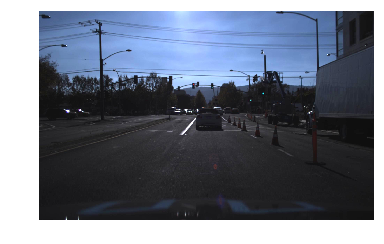

In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import os
import pickle 
import time
import pandas as pd
%matplotlib inline

#read in image
image = mpimg.imread('object-detection-crowdai/1479504050351127195.jpg')
plt.imshow(image);
plt.axis('off');

In [2]:
#checkout pandas dataframe labels
pd_dframe = pd.read_csv('object-detection-crowdai/labels.csv')
print('Size of image data set ', pd_dframe.size)
pd_dframe.head(n=10)

Size of image data set  504448


,xmin,xmax,ymin,ymax,Frame,Label,Preview URL
0,785,533,905,644,1479498371963069978.jpg,Car,http://crowdai.com/images/Wwj-gorOCisE7uxA/vis...
1,89,551,291,680,1479498371963069978.jpg,Car,http://crowdai.com/images/Wwj-gorOCisE7uxA/vis...
2,268,546,383,650,1479498371963069978.jpg,Car,http://crowdai.com/images/Wwj-gorOCisE7uxA/vis...
3,455,522,548,615,1479498371963069978.jpg,Truck,http://crowdai.com/images/Wwj-gorOCisE7uxA/vis...
4,548,522,625,605,1479498371963069978.jpg,Truck,http://crowdai.com/images/Wwj-gorOCisE7uxA/vis...
5,1726,484,1919,646,1479498371963069978.jpg,Car,http://crowdai.com/images/Wwj-gorOCisE7uxA/vis...
6,758,557,807,617,1479498371963069978.jpg,Car,http://crowdai.com/images/Wwj-gorOCisE7uxA/vis...
7,633,561,680,597,1479498371963069978.jpg,Car,http://crowdai.com/images/Wwj-gorOCisE7uxA/vis...
8,682,557,718,593,1479498371963069978.jpg,Car,http://crowdai.com/images/Wwj-gorOCisE7uxA/vis...
9,710,540,836,665,1479498372942264998.jpg,Car,http://crowdai.com/images/c3AY-ptjXfT_oC9F/vis...


In [3]:
#We don't need pedestrians in data set so drop all rows with the pedestrian label, also drop Preview URL
pd_dframe = pd_dframe[pd_dframe.Label != 'Pedestrian']
del pd_dframe['Preview URL']

#Add folder to point to correct training folder
pd_dframe['File_Path'] =  'object-detection-crowdai/' + pd_dframe['Frame']

In [4]:
print('Size of image data set post pedestrian removal ', pd_dframe.size)
#Draw bounding boxes around images given coordinates, each image has multiple bounding boxes annotated to it
pd_dframe.tail()

Size of image data set post pedestrian removal  464723


,xmin,xmax,ymin,ymax,Frame,Label,File_Path
72059,958,559,1045,621,1479506176491553178.jpg,Car,object-detection-crowdai/1479506176491553178.jpg
72060,1038,558,1122,630,1479506176491553178.jpg,Car,object-detection-crowdai/1479506176491553178.jpg
72061,667,558,747,626,1479506176491553178.jpg,Car,object-detection-crowdai/1479506176491553178.jpg
72062,730,568,818,613,1479506176491553178.jpg,Car,object-detection-crowdai/1479506176491553178.jpg
72063,435,551,532,589,1479506176491553178.jpg,Car,object-detection-crowdai/1479506176491553178.jpg


In [5]:
#There is something off about the coordinates, particularly 
#with regards the min max values of bounding box coordinates, 
#further investigations shows that they should be switched arounds as follows:
pd_dframe.columns = ['ymin', 'xmin', 'ymax', 'xmax', 'Frame', 'Label', 'File_Path']
pd_dframe.head()

,ymin,xmin,ymax,xmax,Frame,Label,File_Path
0,785,533,905,644,1479498371963069978.jpg,Car,object-detection-crowdai/1479498371963069978.jpg
1,89,551,291,680,1479498371963069978.jpg,Car,object-detection-crowdai/1479498371963069978.jpg
2,268,546,383,650,1479498371963069978.jpg,Car,object-detection-crowdai/1479498371963069978.jpg
3,455,522,548,615,1479498371963069978.jpg,Truck,object-detection-crowdai/1479498371963069978.jpg
4,548,522,625,605,1479498371963069978.jpg,Truck,object-detection-crowdai/1479498371963069978.jpg


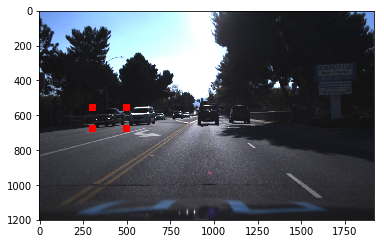

In [6]:
#Pick random image no and confirm that image coordinates all check out
no  = 25003
image_loc = (pd_dframe.iloc[no]['Frame'])
x1 = pd_dframe.iloc[no]['xmin']  
x2 = pd_dframe.iloc[no]['xmax'] 
y1 = pd_dframe.iloc[no]['ymin'] 
y2 = pd_dframe.iloc[no]['ymax']  

image = mpimg.imread('object-detection-crowdai/'+image_loc)
image_sz = image.shape
test = pd_dframe.iloc[no]
#Remember to plot bounding boxes, using y, x coordinates
plt.imshow(image);
plt.plot(y1, x1, 'rs')
plt.plot(y1, x2, 'rs')
plt.plot(y2, x1, 'rs')
plt.plot(y2, x2, 'rs')

In [7]:
#Load other Udacity dataset and merge them
import pandas as pd
pd_dframe2 = pd.read_csv('object-dataset/labels.csv', delimiter=r"\s+",  
                        names= ['Frame',  'xmin', 'xmax', 'ymin','ymax', 'ind', 'Label','RM'])
del pd_dframe2['RM']
del pd_dframe2['ind']
pd_dframe2 =  pd_dframe2[pd_dframe2.Label != 'pedestrian']
#Correct coordinates before concatenating
pd_dframe2.columns = ['Frame', 'ymin', 'xmin', 'ymax', 'xmax', 'Label']
pd_dframe2['File_Path'] =  'object-dataset/' + pd_dframe2['Frame']
#Add folder to Frame values pointing to Udacity training set
pd_dframe2.head(n=10)

,Frame,ymin,xmin,ymax,xmax,Label,File_Path
0,1478019952686311006.jpg,950,574,1004,620,car,object-dataset/1478019952686311006.jpg
2,1478019953180167674.jpg,872,586,926,632,car,object-dataset/1478019953180167674.jpg
3,1478019953689774621.jpg,686,566,728,618,truck,object-dataset/1478019953689774621.jpg
4,1478019953689774621.jpg,716,578,764,622,car,object-dataset/1478019953689774621.jpg
5,1478019953689774621.jpg,826,580,880,626,car,object-dataset/1478019953689774621.jpg
6,1478019953689774621.jpg,1540,488,1680,608,car,object-dataset/1478019953689774621.jpg
7,1478019953689774621.jpg,1646,498,1848,594,car,object-dataset/1478019953689774621.jpg
8,1478019954186238236.jpg,662,562,710,616,truck,object-dataset/1478019954186238236.jpg
9,1478019954186238236.jpg,686,576,730,628,car,object-dataset/1478019954186238236.jpg
10,1478019954186238236.jpg,802,582,856,628,car,object-dataset/1478019954186238236.jpg


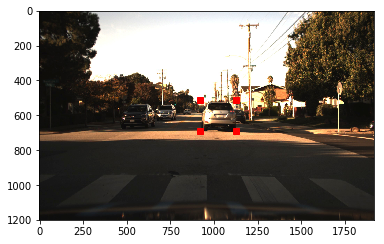

In [8]:
#Pick random image no and confirm that image coordinates all check out
no  = 25001
image_loc = (pd_dframe2.iloc[no]['Frame'])
x1 = pd_dframe2.iloc[no]['xmin']  
x2 = pd_dframe2.iloc[no]['xmax'] 
y1 = pd_dframe2.iloc[no]['ymin'] 
y2 = pd_dframe2.iloc[no]['ymax']  

image = mpimg.imread('object-dataset/'+image_loc)
image_sz = image.shape
test = pd_dframe2.iloc[no]
#Remember to plot bounding boxes, using y, x coordinates
plt.imshow(image);
plt.plot(y1, x1, 'rs')
plt.plot(y1, x2, 'rs')
plt.plot(y2, x1, 'rs')
plt.plot(y2, x2, 'rs')

In [9]:
#Concatenate both dataframes into 1:
pd_dframe = pd.concat([pd_dframe2,pd_dframe]).reset_index()
del pd_dframe['index']

In [10]:
pd_dframe.to_csv('all_labels.csv')

In [11]:
pd_dframe.head(n=5)

,File_Path,Frame,Label,xmax,xmin,ymax,ymin
0,object-dataset/1478019952686311006.jpg,1478019952686311006.jpg,car,620,574,1004,950
1,object-dataset/1478019953180167674.jpg,1478019953180167674.jpg,car,632,586,926,872
2,object-dataset/1478019953689774621.jpg,1478019953689774621.jpg,truck,618,566,728,686
3,object-dataset/1478019953689774621.jpg,1478019953689774621.jpg,car,622,578,764,716
4,object-dataset/1478019953689774621.jpg,1478019953689774621.jpg,car,626,580,880,826


In [12]:
import matplotlib.patches as patches
def get_image_name(df,ind):
    #Get image and resize then return all bounding box coordinates
    
    #Image size
    size=(640,400) 
    #size =(1920, 1200)
    file_name = df.iloc[ind]['File_Path']
    img = cv2.imread(file_name)
    img_size = np.shape(img)
    
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    
    #Resize image
    img = cv2.resize(img,size)
    img_size_post = np.shape(img)
    
    #Load frame name
    name_str = df.iloc[ind]['Frame']
     
    #Get all box coordinates of given image
    bb_boxes = df[df['Frame'] == name_str].reset_index()
     
    #Reshape boxes to fit new image dim
    bb_boxes['xmin'] = np.round(bb_boxes['xmin']/img_size[1]*img_size_post[1])
    bb_boxes['xmax'] = np.round(bb_boxes['xmax']/img_size[1]*img_size_post[1])
    bb_boxes['ymin'] = np.round(bb_boxes['ymin']/img_size[0]*img_size_post[0])
    bb_boxes['ymax'] = np.round(bb_boxes['ymax']/img_size[0]*img_size_post[0])
    
    return img, bb_boxes
 
def get_mask_seg(img,bb_boxes_f): 
    # Get bounding masks   
    img_mask = np.zeros_like(img[:,:,0])
    
    for i in range(len(bb_boxes_f)):
        bb_box_i = [bb_boxes_f.iloc[i]['ymin'],bb_boxes_f.iloc[i]['xmin'],
                bb_boxes_f.iloc[i]['ymax'],bb_boxes_f.iloc[i]['xmax']]
        img_mask[bb_box_i[1]:bb_box_i[3],bb_box_i[0]:bb_box_i[2]]= 1.
        img_mask = np.reshape(img_mask,(np.shape(img_mask)[0],np.shape(img_mask)[1],1))
    return img_mask

def plot_im_bbox(im,bb_boxes):
    #Draw bounding boxes around vehicles
    f, axarr = plt.subplots(1, 2)
    axarr[1].imshow(im)
    axarr[0].set_title('Original image')
    axarr[0].imshow(im)
    for index, row in bb_boxes.iterrows():
        rect = patches.Rectangle(
        (row['ymin'], row['xmin']),   # (x,y)
        row['ymax']-row['ymin'],      # width
        row['xmax'] - row['xmin'],    # height
        )
        axarr[1].add_patch(rect)
        axarr[1].set_title('Cars with bounding boxes')
    plt.show()

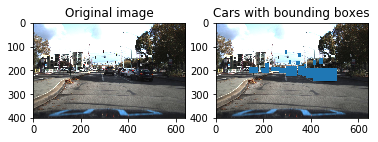

In [15]:
img, bb_boxes = get_image_name(pd_dframe, 3100)
plot_im_bbox(img, bb_boxes)

In [16]:
#Next up make simple data generators
#Test set is comprised of 2000 images examples

img_rows = 400
img_cols = 640
    
def generate_train_batch(data, batch_size = 32):
    #Where data is a pandas dataframe
    batch_images = np.zeros((batch_size, img_rows, img_cols, 3))
    batch_masks = np.zeros((batch_size, img_rows, img_cols, 1))
    
    while 1:
        for i_batch in range(batch_size):
            i_line = np.random.randint(len(data)-2000)
            img,bb_boxes = get_image_name(data, i_line)
            img_mask = get_mask_seg(img,bb_boxes)
            batch_images[i_batch] = img
            batch_masks[i_batch] =img_mask
            
        yield batch_images, batch_masks
        
def generate_test_batch(data,batch_size = 32): 
    batch_images = np.zeros((batch_size, img_rows, img_cols, 3))
    batch_masks = np.zeros((batch_size, img_rows, img_cols, 1))
    
    while 1:
        for i_batch in range(batch_size):
            i_line = np.random.randint(2000)
            img,bb_boxes = get_image_name(data, i_line)
            img_mask = get_mask_seg(img,bb_boxes)
            batch_images[i_batch] = img
            batch_masks[i_batch] =img_mask
            
        yield batch_images, batch_masks

In [17]:
##### Testing the generator
training_gen = generate_train_batch(pd_dframe, 10)

/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/ipykernel/__main__.py:39: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


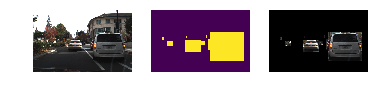

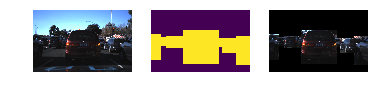

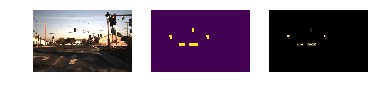

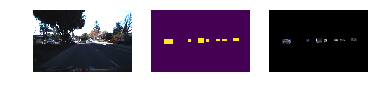

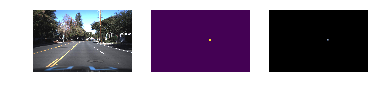

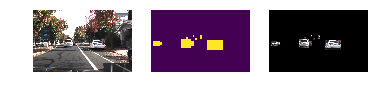

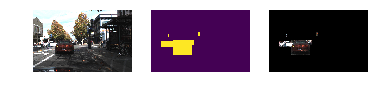

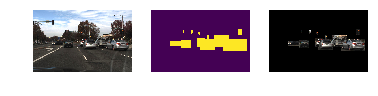

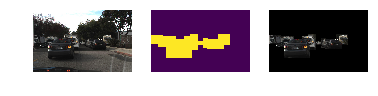

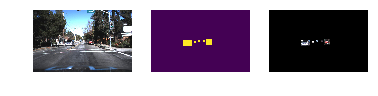

In [18]:
batch_img,batch_mask = next(training_gen)
### Plotting generator output
for i in range(10):
    im = np.array(batch_img[i],dtype=np.uint8)
    im_mask = np.array(batch_mask[i],dtype=np.uint8)
    plt.subplot(1,3,1)
    plt.imshow(im)
    plt.axis('off')
    plt.subplot(1,3,2)
    plt.imshow(im_mask[:,:,0])
    plt.axis('off')
    plt.subplot(1,3,3)
    plt.imshow(cv2.bitwise_and(im,im,mask=im_mask));
    plt.axis('off')
    plt.show();


In [19]:
#Import all scipy, keras and tflow modules
from keras.models import Model
from keras.layers import Input, merge, Convolution2D, MaxPooling2D, UpSampling2D,Lambda
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras import backend as K
from scipy.ndimage.measurements import label
import time

Using TensorFlow backend.


In [20]:
#Awesome looks like all the generators work,
#next up we need to define the (intersection over union) IOU as used when training images segmentation:
smooth = 1.
def IOU_calc_loss(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)    
    return -2*(intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def IOU_calc(y_true, y_pred):
    return -IOU_calc_loss(y_true, y_pred)

In [21]:
### Defining a small Unet
def get_small_unet():
    inputs = Input((img_rows, img_cols,3))
    #Normalize images
    
    #Normal convolution downsampling
    inputs_norm = Lambda(lambda x: x/127.5 - 1.)
    conv1 = Convolution2D(8, 3, 3, activation='relu', border_mode='same')(inputs)
    conv1 = Convolution2D(8, 3, 3, activation='relu', border_mode='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Convolution2D(16, 3, 3, activation='relu', border_mode='same')(pool1)
    conv2 = Convolution2D(16, 3, 3, activation='relu', border_mode='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Convolution2D(32, 3, 3, activation='relu', border_mode='same')(pool2)
    conv3 = Convolution2D(32, 3, 3, activation='relu', border_mode='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Convolution2D(64, 3, 3, activation='relu', border_mode='same')(pool3)
    conv4 = Convolution2D(64, 3, 3, activation='relu', border_mode='same')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Convolution2D(128, 3, 3, activation='relu', border_mode='same')(pool4)
    conv5 = Convolution2D(128, 3, 3, activation='relu', border_mode='same')(conv5)

    #Up convolve and merge previous downsampling
    up6 = merge([UpSampling2D(size=(2, 2))(conv5), conv4], mode='concat', concat_axis=3)
    conv6 = Convolution2D(64, 3, 3, activation='relu', border_mode='same')(up6)
    conv6 = Convolution2D(64, 3, 3, activation='relu', border_mode='same')(conv6)

    up7 = merge([UpSampling2D(size=(2, 2))(conv6), conv3], mode='concat', concat_axis=3)
    conv7 = Convolution2D(32, 3, 3, activation='relu', border_mode='same')(up7)
    conv7 = Convolution2D(32, 3, 3, activation='relu', border_mode='same')(conv7)

    up8 = merge([UpSampling2D(size=(2, 2))(conv7), conv2], mode='concat', concat_axis=3)
    conv8 = Convolution2D(16, 3, 3, activation='relu', border_mode='same')(up8)
    conv8 = Convolution2D(16, 3, 3, activation='relu', border_mode='same')(conv8)

    up9 = merge([UpSampling2D(size=(2, 2))(conv8), conv1], mode='concat', concat_axis=3)
    conv9 = Convolution2D(8, 3, 3, activation='relu', border_mode='same')(up9)
    conv9 = Convolution2D(8, 3, 3, activation='relu', border_mode='same')(conv9)

    #Add sigmoid layer to get segmentaion probability
    conv10 = Convolution2D(1, 1, 1, activation='sigmoid')(conv9)

    model = Model(input=inputs, output=conv10)

    return model

In [22]:
training_gen = generate_train_batch(pd_dframe,1)
smooth = 1.
model = get_small_unet()
model.compile(optimizer=Adam(lr=1e-4),
              loss=IOU_calc_loss, metrics=[IOU_calc])
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 400, 640, 3)   0                                            
____________________________________________________________________________________________________
convolution2d_1 (Convolution2D)  (None, 400, 640, 8)   224         input_1[0][0]                    
____________________________________________________________________________________________________
convolution2d_2 (Convolution2D)  (None, 400, 640, 8)   584         convolution2d_1[0][0]            
____________________________________________________________________________________________________
maxpooling2d_1 (MaxPooling2D)    (None, 200, 320, 8)   0           convolution2d_2[0][0]            
___________________________________________________________________________________________

In [24]:
history = model.fit_generator(training_gen,
            samples_per_epoch=1000,
                              nb_epoch=15)

Epoch 1/15
   1/1000 [..............................] - ETA: 233s - loss: -0.0587 - IOU_calc: 0.0587

/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/ipykernel/__main__.py:39: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


 143/1000 [===>..........................] - ETA: 140s - loss: -0.2546 - IOU_calc: 0.2546

KeyboardInterrupt: 

In [ ]:
model.save('Vehicle_detect_SmallUnet.h5')

In [ ]:
testing_gen = generate_test_batch(pd_dframe,1)
batch_img, batch_mask = next(testing_gen)

In [ ]:
import time

start = time.time()

pred_all= model.predict(batch_img)
end = time.time()
end-start
print(batch_img.shape)

In [ ]:
#Test on last frames of data
for i in range(9):

    im = np.array(batch_img[i],dtype=np.uint8)
    im_mask = np.array(255*batch_mask[i],dtype=np.uint8)
    im_pred = np.array(255*pred_all[i],dtype=np.uint8)

    rgb_mask_pred = cv2.cvtColor(im_pred,cv2.COLOR_GRAY2RGB)
    rgb_mask_pred[:,:,1:3] = 0*rgb_mask_pred[:,:,1:2]
    rgb_mask_true= cv2.cvtColor(im_mask,cv2.COLOR_GRAY2RGB)
    rgb_mask_true[:,:,0] = 0*rgb_mask_true[:,:,0]
    rgb_mask_true[:,:,2] = 0*rgb_mask_true[:,:,2]

    img_pred = cv2.addWeighted(rgb_mask_pred,0.5,im,0.5,0)
    img_true = cv2.addWeighted(rgb_mask_true,0.5,im,0.5,0)

    plt.figure(figsize=(8,3))
    plt.subplot(1,3,1)
    plt.imshow(im)
    plt.title('Original image')
    plt.axis('off')
    plt.subplot(1,3,2)
    plt.imshow(img_pred)
    plt.title('Predicted segmentation mask')
   
    plt.subplot(1,3,3)
    plt.imshow(img_true)
    plt.title('Ground truth BB')
    plt.axis('off')
    plt.show()

In [ ]:
#Load saved model
#Import all scipy, keras and tflow modules
from keras.models import Model
from keras.layers import Input, merge, Convolution2D, MaxPooling2D, UpSampling2D,Lambda
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras import backend as K
from scipy.ndimage.measurements import label
import cv2
import numpy as np
import time
import matplotlib.pyplot as plt
%matplotlib inline

#Redefine loss function
smooth = 1.
def IOU_calc_loss(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)    
    return -2*(intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def IOU_calc(y_true, y_pred):
    return -IOU_calc_loss(y_true, y_pred)

from keras.models import load_model
model = load_model('Vehicle_detect_SmallUnet.h5', 
                   custom_objects={'IOU_calc_loss': IOU_calc_loss, 'IOU_calc': IOU_calc})

In [ ]:
#Draw bounding boxes around model labels
def draw_labeled_bboxes(img, nn_labels):
    img = np.array(img, dtype=np.uint8)
    
    nn_labels = np.array(255*nn_labels, dtype=np.uint8)
    heatmap = nn_labels[:,:,0]
    #Find all non-zero entries in heatmap
    labels = label(heatmap)

    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        if ((np.max(nonzeroy)-np.min(nonzeroy)>40) & (np.max(nonzerox)-np.min(nonzerox)>40)):
            bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
            # Draw the box on the image       
            cv2.rectangle(img, bbox[0], bbox[1], (0,0,255),8)
    #Return the image
    return img

In [ ]:
for i in range(1, 9):
    plt.figure(figsize=(8,3))
    draw_img = draw_labeled_bboxes(batch_img[i], pred_all[i])
    plt.imshow(draw_img)

In [ ]:
#Run net through Udacity p5 test images
#test2 = cv2.imread('test_images/test6.jpg')
test2 = cv2.imread('object-detection-crowdai/1479498378965237962.jpg')

def process_im(img, model):
    img = cv2.resize(img, (640, 400))
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    img_r = np.asarray(img).reshape(1, 400, 640, 3)
    pred = model.predict(img_r)
    bbox = draw_labeled_bboxes(img, pred[0])
    
    return bbox

draw_test = process_im(test2, model) 
plt.imshow(draw_test)